# Assignment 1
**Samuel Sheehy (Student ID 18143565)**

**Techniques of High Performance Computing (PHAS0102)**

**MSc Scientific Computing, University College London**, **2019-2020**

## Setup Notebook
Import libraries that will be used for the completion of both questions.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

## Question 1: Random Walk on a Lattice
The objective is to estimate the probability function of a particle reaching the bottom edge of a lattice as it moves randomly over the lattice. In a fist instance, I implemented a version of the code with no concern for speed, which I then optimised for performance. Only the optimised version is presented here.

The following conventions are set explicitly for reference during the implementation:
* 0 is North, 1 is East, 2 is South, 3 is West
* Moving North decreases position, moving East increases position
* Longitudinal movement is index 0, Latteral movement is index 1
* A run will only finish when a particle reaches an edge
* A run is considered a success when the particle has reached the bottom edge. Otherwise it is considered a failure.

The approach to optimising the code was to consider methods that would both increase execution speed and reduce down time on any of the processors. Thus, instead of performing a run consisting of a sinlge particle placed on the lattice, in a run each lattice point is initialised with particle and a set of random movements is applied to all the particles simultaneously. This allows the algorithm to make use of efficient implementations of vector addition. As the particles progress in their random walks, when one reaches an edge, it is removed from the next round of step execution. This ensures that points to do keep moving once they have reached an edge and that the code is not performing additions on particles that cannot move anyway.

The code is implemented using ```numba```'s JIT compiler. This tool allows the code to run fast and it makes available Numba's parallel processing feature. The ```numexpr``` library was considered for this implementation, but while Numexpr has multicore abilities when Intel's MLK libraries are installed, this is not guaranteed to be the case on every machine. Because ```numexpr``` is nor compatible with ```numba```, this meant that it could not be used in this implementation. Python's ```multiprocessing``` library was also considered; however, considering the simplicity of this program, the overhead for using these features was too high, especially when numba'a automatic parallelisation feature is available.

First the code is presented followed by an analysis of lattice's convergence.

### Perfomance-Optimised Code

In [25]:
#                                                                 #
#     Performance-Optimised Implementation of a Random Walk       # 
#                                                                 #
#                                                                 #

@njit(['float64[:,:](int64)'])
def initialise_starting_points(size):
    """
    Create a set of vectors representing every point
    on the lattice. These are generated all at once so that
    the program can apply steps to each particle in one
    vector addition. This is faster than following only one
    particle at a time.
    """
    number_of_points = size**2
    indexes = np.arange(number_of_points)
    starting_points = np.empty((number_of_points, 2))
    starting_points[:, 0] = indexes%size # Generates column indexes
    starting_points[:, 1] = indexes//size # Generates row indexes
    return starting_points


@njit(['float64[:,:](int64)'])
def generate_random_steps(number_of_points):
    """
    Generate a set of random steps. Numba did not seem
    to support an integer being used to select entries
    from a smaller matrix, so to enable vector-wise generation
    of random steps, this function implements trigonometric functions.
    """
    steps = np.zeros((number_of_points, 2))
    output = np.empty_like(steps)
    directions = np.random.randint(0, 4, (number_of_points))
    steps[:, 0] = np.cos(directions/4*2*np.pi)
    steps[:, 1] = np.sin(directions/4*2*np.pi)
    np.round(steps, 1, output)
    return output
    

@njit(['float64[:,:](float64[:,:], float64[:,:])'])
def step(particles, steps):
    """
    Peform a step on the given particles, returning their new
    position.
    """
    return particles+steps
    
    

@njit(['float64[:,:](float64[:,:])'])
def step_randomly(particles):
    """
    Perform a step in a random direction for each respective
    point provided to the function.
    """
    number_of_points = len(particles)
    steps = generate_random_steps(number_of_points)
    return step(particles, steps)


@njit(['float64[:](float64[:,:], int64)'])
def get_states(particles, size):
    """
    Determine the state of each particle provided: is it on the lower
    border, a different border, or on none.
    """
    states = np.zeros((size**2, 1))
    actual_width = particles[:, 0]
    actual_height = particles[:, 1]
    on_south = actual_height >= (size-1)
    on_north = actual_height <= 0
    on_east = actual_width >= (size-1) 
    on_west = actual_width <= 0 
    states[on_north | on_east | on_west] = 1
    states[on_south] = 2
    return states.flatten() # Return a 1-D array


@njit(['float64[:,:](float64[:,:], int64)'])
def random_walk(particles, size):
    """
    Perform a run on every point in the lattice, by repeatidly stepping
    the points in random directions. Once a particle has reached
    a "finished" state (i.e. it has reached a border), it is filtered
    out from performing new steps to avoid pointless calculations and
    gain some computational efficiency.
    """
    states = get_states(particles, size)
    while particles[states == 0].size > 0:
        particles[states == 0] = step_randomly(particles[states == 0])
        states = get_states(particles, size)
    return particles


@njit(['float64[:](float64[:,:], int64)'])
def get_success(particles, size):
    """
    Determine if the particle has succeeded in reaching the bottom
    edge. 
    """
    states = get_states(particles, size)
    successes = states >= 2 # In the final addition of all the states
                            # the bottom-left and bottom-right corners
                            # come to 3, so the greater-than symbold 
                            # ensures they are included in the success
                            # scale
    return successes*1.0 # Converts from integer to float


@njit(['float64[:,:](int64, int64)'], parallel=True)
def measure_success(iterations, size):
    """
    Perform the measurement of the success rate on all points
    of the lattice for the given number of iterations. This
    implements ```numba```'s automatic parallelisation feature,
    so that multiple experiments can run concurrently.
    """
    # Initialise results container
    results = np.zeros((size**2,), dtype=np.double)
    # Parallel-section
    for _ in prange(iterations):
        # Setup
        particles = initialise_starting_points(size)
        # Run Measurment
        particles = random_walk(particles, size)
        # Save results
        results += get_success(particles, size)
    # Transform number of successes into a fraction based on
    # the total number of runs
    results = results.reshape(size, size)/iterations
    return results


def show_success_map(results_matrix):
    """
    Creates a heatmap of the results using pyplot's imshow. The numbers
    are automatically scaled to fit the colormap.
    """
    plt.imshow(results_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()   

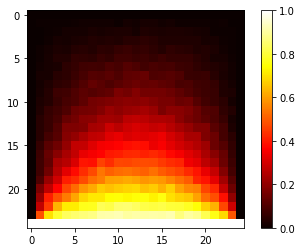

In [26]:
size = 25
iterations = 1000
results = measure_success(iterations, size)
show_success_map(results)

In [4]:
%timeit measure_success(iterations, size)

8.08 s ± 502 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Convergence

In this section we study the convergence of the execution time of the algorithm, first as it increases in iteration count, then as it increases in size.

In [111]:
def multirun_Q1(start, end, step, parameter):
    """
    Run the algorithm multiple times changing the specified parameter
    through the range given with the step given.
    """
    # Defualt parameters
    iterations = 2000
    size = 10
    
    results = []
    iterates = np.linspace(start, end, step)
    for value in iterates:
        if parameter == 'size':
            size = int(value)
        elif parameter == 'iterations':
            iterations = int(value)
        else:
            return
        results.append(
            measure_success(iterations, size)
        )
    return iterates, results


#iterations_space, multi_iterations = multirun_Q1(10, 7000, 100, 'iterations')
sizes, multi_size = multirun_Q1(5, 60, 12, 'size')

In [112]:
sizes

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.])

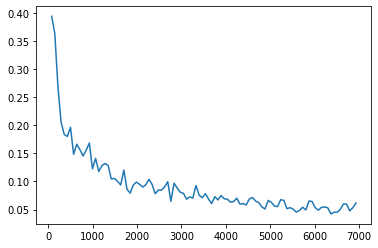

In [118]:
diff = [np.linalg.norm(multi_iterations[i] - multi_iterations[i+1]) for i in range(1, len(multi_iterations)-1)]
plt.plot(iterations_space[1:-1], diff)
plt.show()

In [120]:
iterations_space

array([  10.        ,   80.60606061,  151.21212121,  221.81818182,
        292.42424242,  363.03030303,  433.63636364,  504.24242424,
        574.84848485,  645.45454545,  716.06060606,  786.66666667,
        857.27272727,  927.87878788,  998.48484848, 1069.09090909,
       1139.6969697 , 1210.3030303 , 1280.90909091, 1351.51515152,
       1422.12121212, 1492.72727273, 1563.33333333, 1633.93939394,
       1704.54545455, 1775.15151515, 1845.75757576, 1916.36363636,
       1986.96969697, 2057.57575758, 2128.18181818, 2198.78787879,
       2269.39393939, 2340.        , 2410.60606061, 2481.21212121,
       2551.81818182, 2622.42424242, 2693.03030303, 2763.63636364,
       2834.24242424, 2904.84848485, 2975.45454545, 3046.06060606,
       3116.66666667, 3187.27272727, 3257.87878788, 3328.48484848,
       3399.09090909, 3469.6969697 , 3540.3030303 , 3610.90909091,
       3681.51515152, 3752.12121212, 3822.72727273, 3893.33333333,
       3963.93939394, 4034.54545455, 4105.15151515, 4175.75757

In [121]:
diff

[0.39480625713089634,
 0.3637874584721234,
 0.26871663508290133,
 0.20597475198178697,
 0.18387545917973933,
 0.180334364540447,
 0.19661976858566926,
 0.14848323534022334,
 0.1665388604463034,
 0.15674801115751946,
 0.14556569487092663,
 0.15586532150417248,
 0.1685291357429171,
 0.1226082509907093,
 0.1412202872620842,
 0.1178177762342204,
 0.12792534917287315,
 0.1321257069577049,
 0.12854434623403668,
 0.10468720821666602,
 0.105371376162444,
 0.1002472381684772,
 0.09378750585535828,
 0.12043040772663688,
 0.08634485596380549,
 0.07913665698672474,
 0.09352852487739709,
 0.09890945904484229,
 0.09499726842174443,
 0.08997639261814029,
 0.09419030292110692,
 0.10384896444143298,
 0.09487879178249914,
 0.07821734757779417,
 0.08466690254178735,
 0.08478228083992533,
 0.09049790076001923,
 0.09958414642317007,
 0.06465954204414942,
 0.09706222134712253,
 0.08820165885851705,
 0.08083697070705698,
 0.07871864893847948,
 0.0683866014717911,
 0.07257510051116856,
 0.07050840361185179,
 

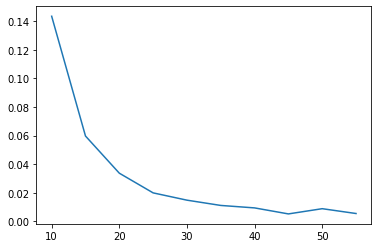

In [113]:
sizes_refactored = [result.reshape(5, (size+1)**2, 5).mean(axis=1)
                    for size, result in zip(range(len(multi_size)), multi_size)]

diff = [np.linalg.norm(sizes_refactored[i] - sizes_refactored[i+1]) for i in range(1, len(sizes_refactored)-1)]
plt.plot(sizes[1:-1], diff)
plt.show()

In [114]:
sizes

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.])

In [115]:
diff

[0.1435965552477229,
 0.05970059918231671,
 0.03367792802322453,
 0.019882474252652948,
 0.014779758202879996,
 0.011084908607692484,
 0.009360269069169279,
 0.005146748935738882,
 0.008806169199616375,
 0.005426553993105305]

#### Analysis of Convergence Results
The plots above illustrate the convergence behviour of the algorithm. According to these measurments, the execution time appears to evolve linearly as the number of iterations increase. Meanwhile the execution time increases exponentially with the increase in lattice size. This is most likely because the number of points that need to be measured inceases quadratically for every increase in the side length.

## Question 2: Potentials Generated by Random Particles
The algorithm here estimates the potential of a collection of particles on a point at a distance away from the centre of these points. The problem was first implemented in Python with no consideration for performance. This code was then optimised for speed and is presented below.

In the first implementation of the calculation, there were three nested loops identified: one repeating over several iterations, one repeating for different values of the radius, and one for every measurement point on a radius.

To optimise the process, the inner most loop was flattened into the middle loop, effectively considering all measurement points across all the radius values in the same iteration.

Similarly to _Q1_, we wanted to use Numba's JIT compilation capability and automatic parallelisation to run the calculations 

### Performance-Optimised Code

In [123]:
#########################################################
#                                                       #
# Performance-Optimised Code for Potential of Particles #
#                                                       #
#########################################################

@njit
def radial_to_cartesian(radial):
    """
    Transform a set of points in radial coordinates
    into the equivalent points in cartesian coordinates
    """
    cartesian = np.empty_like(radial)
    cartesian[:, 0] = radial[:, 1]*np.cos(radial[:, 0])
    cartesian[:, 1] = radial[:, 1]*np.sin(radial[:, 0])
    return cartesian


@njit
def get_measurement_point(m, M, radius):
    """
    Generates the Eucledian coordinates of a measurement
    point based on the index m and the value radius.
    """
    angle = m/M*2*np.pi
    x1 = radius*np.cos(angle)
    x2 = radius*np.sin(angle)
    return np.array([x1, x2])


@njit
def get_rm_index(i, R):
    """
    Convert the singular index i into two coordinates r
    and m which are used to determine which measurment
    point for which the potential will be calculated.
    This is useful for parallelising the calculation
    of the potentials as they can all be calulated
    independentally.
    """
    r = i%R
    m = i//R
    return np.array([r, m])


@njit(['float64(float64[:], float64[:,:])'])
def potential(x, y):
    """
    Calculate the total potential of the particles in y
    acting on the single measurment point x
    """
    distances = np.sqrt((x[0] - y[:, 0])**2 + (x[1] - y[:, 1])**2)
    potentials = 1/(2*np.pi)*np.log(distances)
    potential = np.sum(potentials)
    return potential


@njit(['float64[:,:](int64)'])
def spawn_y(N):
    """
    Creates N random 2-D points in a unit circle,
    unifromly distributed. [See Reference 1].
    """
    N = int(N)
    relative_points = np.random.rand(N, 2)
    relative_points[:, 1] = np.sqrt(relative_points[:, 1])
    relative_points[:, 0] = relative_points[:, 0]*2*np.pi
    return radial_to_cartesian(relative_points)


@njit(['float64[:](float64[:], int64, int64, int64)'], parallel=True)
def calculate_potentials_along_radii(radii, R, M, N):
    """
    Measures the average potential at a distance radius from the
    centre of the group of points. This is implemented 
    """
    y = spawn_y(N)
    potentials = np.zeros((M, R))
    L = R*M
    for j in prange(L):
        coords = get_rm_index(j, R)
        x = get_measurement_point(coords[1], M, radii[coords[0]])
        potentials[coords[1], coords[0]] = potential(x, y)/N
    potentials_per_radius = np.sum(potentials, axis=0)/M
    return potentials_per_radius
    

@njit(['float64[:](float64, float64, int64, int64, int64, int64)'])
def fast_calculate_multi_radii(low, high, R, M, N, iterations):
    """
    Calculate the average potential for N points evenly
    spaced in the range [low, high].
    """
    results = np.zeros((R, ))
    radii = np.linspace(low, high, R)
    for _ in prange(iterations):
        potentials_per_radius = calculate_potentials_along_radii(radii, R, M, N)
        results += potentials_per_radius
    return results/iterations


def show_particles(y):
    """
    Show a scatter plot of the points y.
    """
    plt.scatter(y[:, 0], y[:, 1])
    plt.show()


def single_centre_potential(radius):
    """
    Calculate the uniform potential of a particle at the centre
    of a circle of the given radius on a point on the
    circumfrence.
    """
    return np.log(radius)/(2*np.pi)


def relative_error(centre_point_values, aggregate_values):
    """
    Calculate the relative error for each set of points
    """
    difference = np.linalg.norm(
        centre_point_values - aggregate_values, axis=0
    )
    return np.divide(difference, centre_point_values)


def single_centre_multi_radii(low, high, R):
    """
    Calculates the single centre potential for multiple
    radii.
    """
    radii = np.linspace(low, high, R)
    return np.array([
        single_centre_potential(radius)
        for radius in radii
    ]).reshape(R, 1)


def plot_potential(low, high, R, M, N, iterations):
    """
    Plot the potential for various radii.
    """
    r = np.linspace(low, high, R)
    potentials = fast_calculate_multi_radii(low, high, R, M, N, iterations)
    plt.plot(r, potentials)
    plt.xlabel('Radius')
    plt.ylabel('Potential')
    plt.title('Potential Away From Particles')
    plt.show()
    return r, potentials.reshape(R, 1)

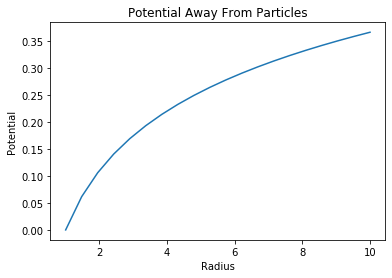

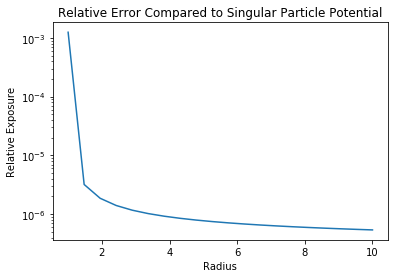

In [127]:
# Parameters
N = 1000
low = 1.001
high = 10
R = 20
M = 100
iterations = 200

# Commands
exact = single_centre_multi_radii(low, high, R)
r, exper = plot_potential(low, high, R, M, N, iterations)
E = relative_error(exact, exper)

# Plotting
plt.semilogy(r, E, label='fast')
plt.xlabel('Radius')
plt.ylabel('Relative Exposure')
plt.title('Relative Error Compared to Singular Particle Potential')
plt.show()

In [26]:
%timeit fast_calculate_multi_radii(low, high, R, M, N, iterations)

1.52 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Convergence

This section reviews how each parameter affects the execution time of the code.

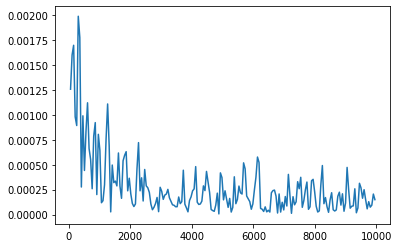

In [131]:
def multirun_Q2(start, end, points, parameter):
    """
    Measure the runtime of the program for various values of the
    given parameter
    """
    low = 0.001
    high = 10
    M = 10
    N = 100
    iterations = 50
    iterates = np.linspace(start, end, points)
    
    results = []
    
    for i, value in enumerate(iterates):
        if parameter == 'M':
            M = int(value)
        elif parameter == 'N':
            N = int(value)
        elif parameter == 'iterations':
            iterations = int(value)
        else:
            return
        
        results.append(
            fast_calculate_multi_radii(low, high, R, M, N, iterations)
        )
        
    return iterates, results


def difference_calculate(iterates, results):
    """
    """
    diff = [np.linalg.norm(results[i] - results[i+1]) for i in range(1, len(results)-1)]
    return iterates[1:-1], diff

N_space, N_res = multirun_Q2(10, 10000, 200, 'N')
# M_space, M_res = multirun_Q2(10, 1000, 20, 'M')
# iter_space, iter_res = multirun_Q2(10, 500, 20, 'iterations')

plt.plot(*difference_calculate(N_space, N_res))

In [138]:
difference_calculate(N_space, N_res)

(array([  60.20100503,  110.40201005,  160.60301508,  210.8040201 ,
         261.00502513,  311.20603015,  361.40703518,  411.6080402 ,
         461.80904523,  512.01005025,  562.21105528,  612.4120603 ,
         662.61306533,  712.81407035,  763.01507538,  813.2160804 ,
         863.41708543,  913.61809045,  963.81909548, 1014.0201005 ,
        1064.22110553, 1114.42211055, 1164.62311558, 1214.8241206 ,
        1265.02512563, 1315.22613065, 1365.42713568, 1415.6281407 ,
        1465.82914573, 1516.03015075, 1566.23115578, 1616.4321608 ,
        1666.63316583, 1716.83417085, 1767.03517588, 1817.2361809 ,
        1867.43718593, 1917.63819095, 1967.83919598, 2018.04020101,
        2068.24120603, 2118.44221106, 2168.64321608, 2218.84422111,
        2269.04522613, 2319.24623116, 2369.44723618, 2419.64824121,
        2469.84924623, 2520.05025126, 2570.25125628, 2620.45226131,
        2670.65326633, 2720.85427136, 2771.05527638, 2821.25628141,
        2871.45728643, 2921.65829146, 2971.85929

In [137]:
N_res

[array([-0.07617047, -0.05728314,  0.00831808,  0.07278075,  0.11854108,
         0.15404034,  0.18304764,  0.20757428,  0.22882106,  0.24756262,
         0.2643279 ,  0.27949424,  0.29334024,  0.3060775 ,  0.31787048,
         0.3288496 ,  0.33911997,  0.34876756,  0.35786362,  0.3664678 ]),
 array([-0.08098564, -0.05724522,  0.0083406 ,  0.07278095,  0.11854109,
         0.15404034,  0.18304764,  0.20757428,  0.22882106,  0.24756262,
         0.2643279 ,  0.27949424,  0.29334024,  0.3060775 ,  0.31787048,
         0.3288496 ,  0.33911997,  0.34876756,  0.35786362,  0.3664678 ]),
 array([-0.0797841 , -0.05761069,  0.00829368,  0.07278006,  0.11854104,
         0.15404034,  0.18304764,  0.20757428,  0.22882106,  0.24756262,
         0.2643279 ,  0.27949424,  0.29334024,  0.3060775 ,  0.31787048,
         0.3288496 ,  0.33911997,  0.34876756,  0.35786362,  0.3664678 ]),
 array([-0.07834215, -0.05691843,  0.008284  ,  0.07278003,  0.11854104,
         0.15404034,  0.18304764,  0.20757428

# References

[1] https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly/50746409#50746409
